<p style="font-size:32px;text-align:center"><b><font color=DarkMagenta>Amazon Apparel Recommendations</font></b></p>

<h3><font color=MediumVioletRed>Loading Data</font></h3>

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import requests
from io import BytesIO
from matplotlib import gridspec

from sklearn.metrics import pairwise_distances
from IPython.display import display, Image, SVG, Math, YouTubeVideo

import os
os.chdir("D:/Amazon Apparel Recommendations")

In [3]:
#read the data from pickle file as we saved at the end of part1
apparel_data = pd.read_pickle("16k_apperal_data_preprocessed")

In [4]:
apparel_data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [5]:
print("NUMBER OF DATA-POINTS -",apparel_data.shape[0])
print("NUMBER OF FEATURES/COLUMNS -",apparel_data.shape[1])

NUMBER OF DATA-POINTS - 16042
NUMBER OF FEATURES/COLUMNS - 7


<p style="font-size:22px;text-align:center"><b><font color=Turquoise>Title (Text) Based Product Similarity</font></b></p>

<h3><b><font color=Crimson>1 - Bag of Words (BoW)</font></b></h3>

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
bow_title_vectorizer = CountVectorizer()
bow_title_features = bow_title_vectorizer.fit_transform(apparel_data['title'])

In [7]:
bow_title_features.get_shape() #get number of rows and columns in feature matrix

(16042, 12609)

<h3><b><font color=Crimson>2 - TF IDF</font></b></h3>

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(apparel_data['title'])

In [9]:
tfidf_title_features.get_shape() #get number of rows and columns in feature matrix

(16042, 12609)

<h3><b><font color=Coral>3. Text Semantics Based Product Similarity</font></b></h3>

In [10]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [11]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(apparel_data['title'])
idf_title_features.get_shape() #get number of rows and columns in feature matrix

(16042, 12609)

In [12]:
#vocab = stores all the words that are there in google w2v model
#vocab = model.wv.vocab.keys() # if you are using Google word2Vec
vocab = model.keys()
#this function will add the vectors of each word and returns the avg vector of given sentance

def build_avg_vec(sentence, num_features, doc_id, m_name):
    #sentace: its title of the apparel
    #num_features: the lenght of word2vec vector, its values = 300
    #m_name: model information it will take two values
        #if  m_name == 'avg', we will append the model[i], w2v representation of word i
        #if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features), dtype="float32")
    #we will intialize a vector of size 300 with all zeros
    #we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'idf_weighted' and word in idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
            elif m_name == 'tf_idf_weighted'and word in tfidf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[word]] * model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    #returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

<h3><b><font color=Crimson>3.a - Average Word2Vec</font></b></h3>

In [14]:
doc_id = 0
avg_w2v_title = []
#for every title we build a avg vector representation
for i in apparel_data['title']:
    avg_w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

#avg_w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
avg_w2v_title = np.array(avg_w2v_title)

In [15]:
avg_w2v_title.shape

(16042, 300)

<h3><b><font color=Crimson>3.b - IDF Weighted Word2Vec</font></b></h3>

In [16]:
doc_id = 0
idf_w2v_title_weight = []
#for every title we build a weighted vector representation
for i in apparel_data['title']:
    idf_w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'idf_weighted'))
    doc_id += 1
#w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
idf_w2v_title_weight = np.array(idf_w2v_title_weight)

In [17]:
idf_w2v_title_weight.shape

(16042, 300)

<h3><b><font color=Crimson>3.c - TF IDF Weighted Word2Vec</font></b></h3>

In [18]:
doc_id = 0
tf_idf_w2v_title_weight = []
#for every title we build a weighted vector representation
for i in apparel_data['title']:
    tf_idf_w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'tf_idf_weighted'))
    doc_id += 1
#w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
tf_idf_w2v_title_weight = np.array(tf_idf_w2v_title_weight)

In [19]:
tf_idf_w2v_title_weight.shape

(16042, 300)

<p style="font-size:22px;text-align:center"><b><font color=Turquoise>Brand and Color Based Product Similarity</font></b></p>

<h3><b><font color=Crimson>One Hot Encoding (Weighted Similarity Using Brand & Color)</font></b></h3>

In [20]:
#some of the brand values are empty. 
#need to replace Null with string "NULL"
apparel_data['brand'].fillna(value="Not Given", inplace=True)

#replace spaces with hypen
brands = [x.replace(" ", "-") for x in apparel_data['brand'].values]
colors = [x.replace(" ", "-") for x in apparel_data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

<p style="font-size:22px;text-align:center"><b><font color=Turquoise>Image Based Product Similarity</font></b></p>

<h3><b><font color=Crimson>Visual Features Based Product Similarity</font></b></h3>

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

#load the features and corresponding ASINS info
bottleneck_features_train = np.load('16k_data_cnn_features.npy')

asins = np.load('16k_data_cnn_feature_asins.npy')

asins = list(asins)
df_asins = list(apparel_data['asin'])

<p style="font-size:22px;text-align:center"><b><font color=Turquoise>Product Similarity</font></b></p>

In [95]:
def get_similar_products(title_technique, doc_id, wt, wb, wc, wi, num_results):
    doc_id = asins.index(df_asins[doc_id])
    
    title_dist  = pairwise_distances(title_technique, title_technique[doc_id].reshape(1,-1))
    brand_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_dist = pairwise_distances(color_features, color_features[doc_id])
    bottleneck_features_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
    pairwise_dist = (wt * title_dist +  wb * brand_dist + wc * color_dist + wi * bottleneck_features_dist)/float(wt + wb + wc + wi)

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    for i in range(len(indices)):
        rows = apparel_data[['medium_image_url','title','brand','color']].loc[apparel_data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Brand:', row['brand'])
            print('Color:', row['color'])
            print('Euclidean Distance From The Query Image:', pdists[i])
            print('Amazon URL: www.amzon.com/dp/'+ asins[indices[i]])

<p style="font-size:15px">For Title text, we have bunch of techniques;<br><br>
**BoW** - bow_title_features<br>
**TF-IDF** - tfidf_title_features<br>
**Average Word2Vec** - avg_w2v_title<br>
**IDF Weighted W2V** - idf_w2v_title_weight<br>
**TFIDF Weighted W2V** - tf_idf_w2v_title_weight</p>

_We can easily use any of above technique in the given function._<br>

<font color=blue>get_similar_products</font>(title_technique, doc_id, wt, wb, wc, wi, num_results):<br>
where,<br>
title_technique - _use any of above technique for title text vector_<br>
wt - _title vector weight_<br>
wb - _brand vector weight_<br>
wc - _color vector weight_<br>
wi - _image vector weight_<br>
num_results - _number of results_

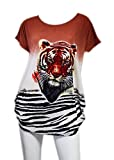

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 3.373845247551799e-06
Amazon URL: www.amzon.com/dp/B00JXQB5FQ


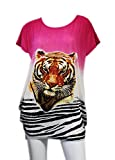

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Pink
Euclidean Distance From The Query Image: 16.95807681260898
Amazon URL: www.amzon.com/dp/B00JXQASS6


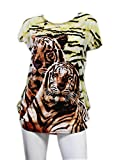

Product Title:  yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Color: Yellow
Euclidean Distance From The Query Image: 22.787518878808765
Amazon URL: www.amzon.com/dp/B00JXQCUIC


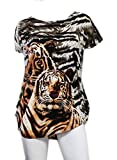

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 24.128358339277394
Amazon URL: www.amzon.com/dp/B00JXQCWTO


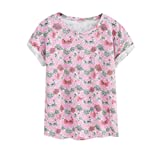

Product Title:  kawaii pastel tops tees pink flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 26.120131982650587
Amazon URL: www.amzon.com/dp/B071FCWD97


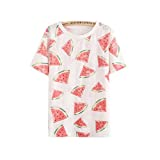

Product Title:  womens thin style tops tees pastel watermelon print 
Brand: Namnoi Clothing Store
Color: As show
Euclidean Distance From The Query Image: 26.16962557080502
Amazon URL: www.amzon.com/dp/B01JUNHBRM


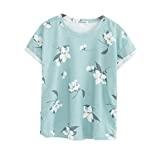

Product Title:  kawaii pastel tops tees baby blue flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 26.219242935784152
Amazon URL: www.amzon.com/dp/B071SBCY9W


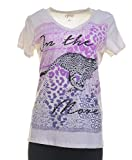

Product Title:  edv cheetah run purple multi xl 
Brand: Styleco
Color: White
Euclidean Distance From The Query Image: 26.382465447639824
Amazon URL: www.amzon.com/dp/B01CUPYBM0


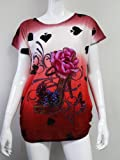

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Brand: Si Row
Color: Red
Euclidean Distance From The Query Image: 26.408263100813976
Amazon URL: www.amzon.com/dp/B00JV63QQE


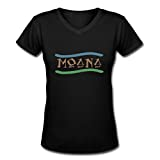

Product Title:  moana logo adults hot v neck shirt black xxl 
Brand: BOBOB
Color: Black
Euclidean Distance From The Query Image: 26.413662332019467
Amazon URL: www.amzon.com/dp/B01LX6H43D


In [104]:
#title_technique - idf_w2v_title_weight
#wt - title vector weight = 10     #wb - brand vector weight = 50
#wc - color vector weight = 10     #wi - image vector weight = 80
get_similar_products(idf_w2v_title_weight, 12566, 10, 50, 10, 80, 10)

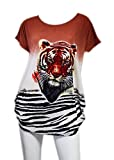

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 2.530383935663849e-06
Amazon URL: www.amzon.com/dp/B00JXQB5FQ


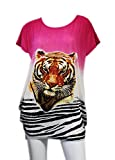

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Pink
Euclidean Distance From The Query Image: 12.626594315317861
Amazon URL: www.amzon.com/dp/B00JXQASS6


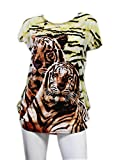

Product Title:  yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Color: Yellow
Euclidean Distance From The Query Image: 17.22285494363772
Amazon URL: www.amzon.com/dp/B00JXQCUIC


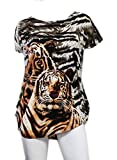

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 18.317881150626008
Amazon URL: www.amzon.com/dp/B00JXQCWTO


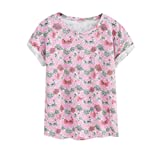

Product Title:  kawaii pastel tops tees pink flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 19.644639535312525
Amazon URL: www.amzon.com/dp/B071FCWD97


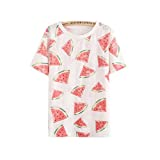

Product Title:  womens thin style tops tees pastel watermelon print 
Brand: Namnoi Clothing Store
Color: As show
Euclidean Distance From The Query Image: 19.79236479318606
Amazon URL: www.amzon.com/dp/B01JUNHBRM


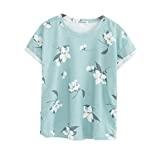

Product Title:  kawaii pastel tops tees baby blue flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 19.952649178885284
Amazon URL: www.amzon.com/dp/B071SBCY9W


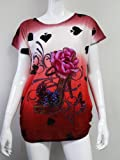

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Brand: Si Row
Color: Red
Euclidean Distance From The Query Image: 19.958432870273462
Amazon URL: www.amzon.com/dp/B00JV63QQE


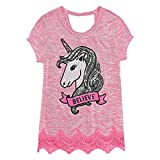

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Brand: MISS CHIEVOUS/AROUND THE WORLD APP
Color: Black
Euclidean Distance From The Query Image: 19.97539475513433
Amazon URL: www.amzon.com/dp/B0177DM70S


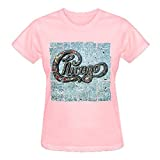

Product Title:  chicago chicago 18 shirt women pink 
Brand: Tony Arden
Color: Pink
Euclidean Distance From The Query Image: 19.988787307775397
Amazon URL: www.amzon.com/dp/B01GXAZTRY


In [102]:
#title_technique - avg_w2v_title
#wt - title vector weight = 100     #wb - brand vector weight = 10
#wc - color vector weight = 10     #wi - image vector weight = 80
get_similar_products(avg_w2v_title, 12566, 100, 10, 10, 80, 10)

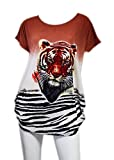

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 2.6496166865590042e-06
Amazon URL: www.amzon.com/dp/B00JXQB5FQ


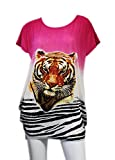

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Pink
Euclidean Distance From The Query Image: 13.869144981359534
Amazon URL: www.amzon.com/dp/B00JXQASS6


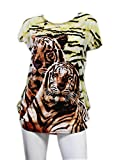

Product Title:  yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Color: Yellow
Euclidean Distance From The Query Image: 18.300985370265064
Amazon URL: www.amzon.com/dp/B00JXQCUIC


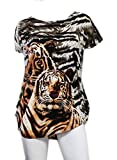

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 19.267898057838988
Amazon URL: www.amzon.com/dp/B00JXQCWTO


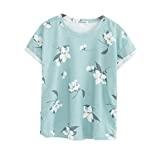

Product Title:  kawaii pastel tops tees baby blue flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 20.90220480072184
Amazon URL: www.amzon.com/dp/B071SBCY9W


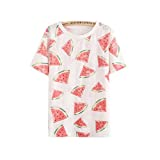

Product Title:  womens thin style tops tees pastel watermelon print 
Brand: Namnoi Clothing Store
Color: As show
Euclidean Distance From The Query Image: 20.953263005479297
Amazon URL: www.amzon.com/dp/B01JUNHBRM


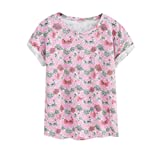

Product Title:  kawaii pastel tops tees pink flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 20.991272828847837
Amazon URL: www.amzon.com/dp/B071FCWD97


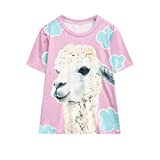

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Brand: Namnoi Clothing Store
Color: As show
Euclidean Distance From The Query Image: 21.019400664494402
Amazon URL: www.amzon.com/dp/B01I80A93G


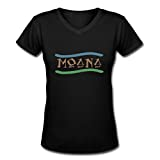

Product Title:  moana logo adults hot v neck shirt black xxl 
Brand: BOBOB
Color: Black
Euclidean Distance From The Query Image: 21.06471482223611
Amazon URL: www.amzon.com/dp/B01LX6H43D


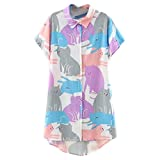

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Brand: ABADAY
Color: Multi
Euclidean Distance From The Query Image: 21.068536401110904
Amazon URL: www.amzon.com/dp/B01CR57YY0


In [100]:
#title_technique - tfidf_title_features
#wt - title vector weight = 1     #wb - brand vector weight = 100
#wc - color vector weight = 10     #wi - image vector weight = 80
get_similar_products(tfidf_title_features, 12566, 1, 100, 10, 80, 10)

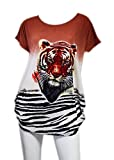

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 3.9291676019624986e-07
Amazon URL: www.amzon.com/dp/B00JXQB5FQ


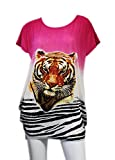

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Pink
Euclidean Distance From The Query Image: 3.8051937868357655
Amazon URL: www.amzon.com/dp/B00JXQASS6


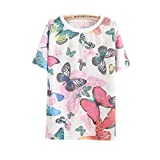

Product Title:  cute pastel tops tees colorful butterfly design print size 
Brand: Namnoi Cute Tee Top
Color: As show
Euclidean Distance From The Query Image: 4.118904316759681
Amazon URL: www.amzon.com/dp/B019E3TD10


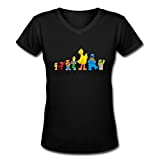

Product Title:  adults cotton custom sesame street live family v neck shirt black xxl 
Brand: Jessico
Color: Black
Euclidean Distance From The Query Image: 4.1192796220332
Amazon URL: www.amzon.com/dp/B01LWTSLVC


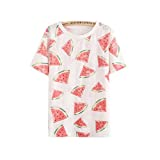

Product Title:  womens thin style tops tees pastel watermelon print 
Brand: Namnoi Clothing Store
Color: As show
Euclidean Distance From The Query Image: 4.125464550300368
Amazon URL: www.amzon.com/dp/B01JUNHBRM


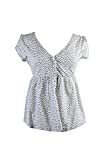

Product Title:  denim  supply ralph lauren womens floral print scalloped blouse multi 
Brand: Denim & Supply
Color: Blue
Euclidean Distance From The Query Image: 4.126437011639948
Amazon URL: www.amzon.com/dp/B06XG3CP9S


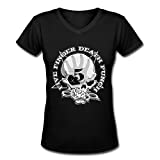

Product Title:  five finger death punch womens pink print 2014 tour girls jr soft tee black 
Brand: Five Finger Death Punch
Color: 02Black
Euclidean Distance From The Query Image: 4.128690960726806
Amazon URL: www.amzon.com/dp/B0148ROP3S


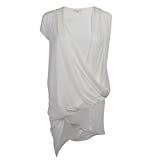

Product Title:  gold hawk womens asymmetrical silk tank white large 
Brand: Gold Hawk
Color: White
Euclidean Distance From The Query Image: 4.134229604984346
Amazon URL: www.amzon.com/dp/B01MY7BA8I


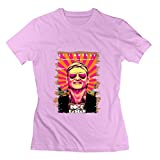

Product Title:  womens rock kasbah movie bill murray tshirts casual pink size l 
Brand: Cherish Tee
Color: Pink
Euclidean Distance From The Query Image: 4.137308670609317
Amazon URL: www.amzon.com/dp/B017N7DWYI


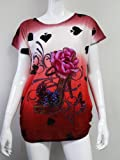

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Brand: Si Row
Color: Red
Euclidean Distance From The Query Image: 4.153187050981504
Amazon URL: www.amzon.com/dp/B00JV63QQE


In [105]:
#title_technique - tf_idf_w2v_title_weight
#wt - title vector weight = 1     #wb - brand vector weight = 50
#wc - color vector weight = 100     #wi - image vector weight = 10
get_similar_products(tf_idf_w2v_title_weight, 12566, 1, 50, 100, 10, 10)

#by just giving maximum weight to the color, the result doesn't change much #bow_title_features

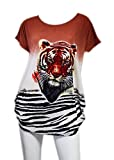

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 9.488940122537315e-07
Amazon URL: www.amzon.com/dp/B00JXQB5FQ


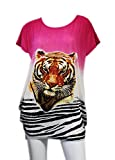

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Brand: Si Row
Color: Pink
Euclidean Distance From The Query Image: 6.92555962351552
Amazon URL: www.amzon.com/dp/B00JXQASS6


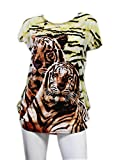

Product Title:  yellow tiger tshirt tiger stripes  l 
Brand: Si Row
Color: Yellow
Euclidean Distance From The Query Image: 8.355192884253189
Amazon URL: www.amzon.com/dp/B00JXQCUIC


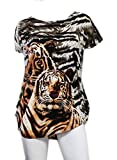

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Brand: Si Row
Color: Brown
Euclidean Distance From The Query Image: 8.666524721060153
Amazon URL: www.amzon.com/dp/B00JXQCWTO


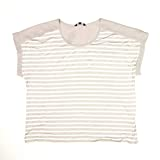

Product Title:  christian siriano womens runway style chiffon sleeve blouse xxlarge grey stripe 
Brand: Christian Siriano
Color: Grey Stripe
Euclidean Distance From The Query Image: 8.857377756058327
Amazon URL: www.amzon.com/dp/B00L4KJY5M


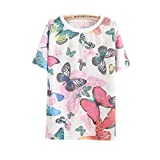

Product Title:  cute pastel tops tees colorful butterfly design print size 
Brand: Namnoi Cute Tee Top
Color: As show
Euclidean Distance From The Query Image: 9.036006927670922
Amazon URL: www.amzon.com/dp/B019E3TD10


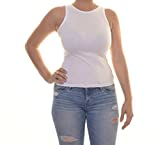

Product Title:  energie white tank top sleeveless size xs nwt  movaz 
Brand: Energie
Color: White
Euclidean Distance From The Query Image: 9.049970213850578
Amazon URL: www.amzon.com/dp/B00Z8RY6EG


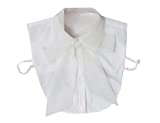

Product Title:  original fashion detachable shirt false collarelegant organza false collar 
Brand: Black Temptation
Color: Blank
Euclidean Distance From The Query Image: 9.088427391813433
Amazon URL: www.amzon.com/dp/B00WQWRLR0


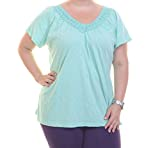

Product Title:  jm collection plus size shortsleeve crochettrim top size 0x 
Brand: JM Collection
Color: Clear Mint
Euclidean Distance From The Query Image: 9.09151287153124
Amazon URL: www.amzon.com/dp/B01GQNE4XI


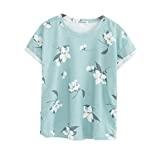

Product Title:  kawaii pastel tops tees baby blue flower design 
Brand: Namnoi Clothing Store
Color: As Show
Euclidean Distance From The Query Image: 9.101515985839361
Amazon URL: www.amzon.com/dp/B071SBCY9W


In [106]:
#title_technique - bow_title_features
#wt - title vector weight = 60     #wb - brand vector weight = 100
#wc - color vector weight = 10     #wi - image vector weight = 30
get_similar_products(bow_title_features, 12566, 60, 100, 10, 30, 10)

#shows completely different results

<h3><font color=MediumVioletRed>Summary and Observation</font></h3>

<p style="font-size:15px">Here we used Title text, Brand, Color and Image features to recommend similar products.<br><br>
1. For Title text, we used bunch of techniques; **BoW, TF-IDF, Average Word2Vec, IDF Weighted W2V** and **TFIDF Weighted W2V**.<br>
_And It is observed that, by just changing title text technique, the result doesn't change much._<br>
2. For Brand and Color, we used **One-Hot-Encoding Technique** and<br>
3. For Image, used one of the very popolar ConvNet - **VGG16**.<br><br>
After constructing all these vectors, we concatenated them.<br><br>
Now let's assume, we want to prefer showing our customers the products of the same brand OR If we want to pick or show products of the same color, then all we have to modify the **Euclidean Distance**, simply take **Weighted Euclidean Distance**.<br>
For that, we have to assign _weights_ to each vector and simply multiply each elements of the vector with the assigned weights. After multiplying, just take the Euclidean Distance, which is extractedly similar to the Weighted Euclidean Distance in concept.<br><br>
After doing this, what we get;
<font color=red>For Eg.</font><br>
<p style="text-align:center">Weight for Title = 10<br>
Weight for Brand = 50<br>
Weight for Color = 20<br>
Weight for Image = 10<br><br></p>
In this case, since the brand weight is greater, we end up preferring products of the same brand. **By just changing the weight, we can easily give our preference for the same brand or color**.
</p>